In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [3]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [22, 10]

In [19]:
data=pd.read_csv('/content/drive/My Drive/data_dump.csv')

In [40]:
#number of rows and columns in the dataset
data.shape

(8523, 678)

In [8]:
#to get a dataset that filters based on the condition that each chiller is ON
data_combined = data[(data['ACPC-1Comp_Power']>10) & (data['ACPC-2Comp_Power']>10) & (data['ACPC-3Comp_Power']>10) & (data['ACPC-4Comp_Power']>10)]
data_combined.shape

(154, 678)

In [42]:
data_power_combined=data.loc[:, ['timestamp', 'ACPC-1Comp_Power','ACPC-2Comp_Power','ACPC-3Comp_Power', 'ACPC-4Comp_Power']]
data_power_combined.corr()

#not a lot of linear correlation between the chillers which is surprising because I assumed they worked together and shared load

,ACPC-1Comp_Power,ACPC-2Comp_Power,ACPC-3Comp_Power,ACPC-4Comp_Power
ACPC-1Comp_Power,1.000000,0.056530,0.139203,0.010440
ACPC-2Comp_Power,0.056530,1.000000,0.236429,-0.044152
ACPC-3Comp_Power,0.139203,0.236429,1.000000,0.045477
ACPC-4Comp_Power,0.010440,-0.044152,0.045477,1.000000


In [39]:
# calculate the spearman's correlation between two variables as a nonparametric 
# measure of the monotonicity of the relationship between two variables
from numpy.random import rand
from numpy.random import seed
from scipy.stats import spearmanr
# seed random number generator
seed(1)
# calculate spearman's correlation
coef, p = spearmanr(a=data_power_combined.iloc[:, 1:], nan_policy='omit')
  #  data['ACPC-3Comp_Power'], data['ACPC-2CHW_Temp_Diff'], nan_policy='omit')
#print('Spearmans correlation coefficient: %.3f' % coef)
print(coef)


[[ 1.         -0.0825558  -0.04999128  0.07684273]
 [-0.0825558   1.          0.07006263 -0.05800746]
 [-0.04999128  0.07006263  1.         -0.13728556]
 [ 0.07684273 -0.05800746 -0.13728556  1.        ]]


The lack of correlation between the activity of the chillers shows us that it might be better to consider each chiller's data separately.

In [53]:
data1 = data[(data['ACPC-1Comp_Power']>10)]
data2 = data[(data['ACPC-2Comp_Power']>10)]
data3 = data[(data['ACPC-3Comp_Power']>10)]
data4 = data[(data['ACPC-4Comp_Power']>10)]

The analysis below only deals with the data for Chiller 1. However, it can be easily repeated for the other chillers.

In [44]:
data1[['ACPC-1CHW_Temp_Diff']].describe()

,ACPC-1CHW_Temp_Diff
count,2166.000000
mean,2.468695
std,0.757973
min,-3.714115
25%,1.962260
50%,2.358469
75%,2.764104
max,9.407415


In [45]:
#one delta_T reading is negative but that's probably because of an issue with the sensor. 
data1[data1['ACPC-1CHW_Temp_Diff']<0]

,timestamp,CHWP-004Power_Factor,CHWP-004Speed_SP,CHWP-004KWh,CHWP-004Speed_Meter,CHWP-004Override_Enable,CHWP-004Running_Hours,CHWP-004Speed_Override_SP,CHWP-004VSD_Speed_Feedback,CHWP-004Remote_Control-1,CHWP-004Master_Trip_Alarm,CHWP-004VSD_Speed_Control,CHWP-004Seq,CHWP-004Override_ON_OFF,CHWP-004Local_Remote_Status,CHWP-004KVA,CHWP-004Running_Status,CHWP-004Remote_Control-2,CHWP-004Speed_Override_Enable,CHWP-004Start_Stop_Control,CHWP-004Enable,CHWP-004KW,CHWP-004Drivers.BacnetNetwork.New Chiller Plant.points.CHWP-004 Diff. Pressure,CHWP-004Diff_Pressure,CHWP-004on,ACPC-4Active_Chilled_Water_Setpoint,ACPC-4Average_Input_Current_AFD_1A,ACPC-4Evap_Approach_ckt1,ACPC-4Running_Status,ACPC-4Cond_Sat_Ref_Temperature_Ckt1,ACPC-4Chilled_Water_Setpoint,ACPC-4Cond_Sat_Ref_Temperature_Ckt2,ACPC-4CHWS_Temp,ACPC-4Evap_Sat_Ref_Temperature_Ckt1,ACPC-4Diff_Ref_Pressure_Ckt1,ACPC-4Outdoor_Air_Temperature,ACPC-4Valve_Remote_Control-1,ACPC-4Local_Remote_Start,ACPC-4Chiller_Loading_Percent,ACPC-4Evaporator_Leaving_Water_Temperature,...,AHU-045Drivers.TrendIpNetwork.SHT-ECS-AHU-045 OS37.points.Sensor.MODULATING VALVE STATUS,AHU-041Drivers.TrendIpNetwork.SHT-ECS-AHU-041 OS32.points.Sensor.RETURN AIR TEMP,AHU-041Drivers.TrendIpNetwork.SHT-ECS-AHU-041 OS32.points.Sensor.SUPPLY AIR TEMP,AHU-041Drivers.TrendIpNetwork.SHT-ECS-AHU-041 OS32.points.Sensor.MODULATING VALVE STATUS,AHU-041Drivers.TrendIpNetwork.SHT-ECS-AHU-041 OS32.points.DI.AHU ON OFF STATUS,MOD-001&2Drivers.TrendIpNetwork.SHT-ECS-MOD-001&2 OS23.points.Sensor.OUTDOOR AIR TEMP,MOD-001&2Drivers.TrendIpNetwork.SHT-ECS-MOD-001&2 OS23.points.DI.RETURN AIR DAMPER STATUS,MOD-001&2Drivers.TrendIpNetwork.SHT-ECS-MOD-001&2 OS23.points.Sensor.OUTDOOR AIR RH,Test pointsconn_status_1,Test pointsconn_status_3,Test pointsconn_status_2,Chiller HeaderAdd_Chiller_SetPoint_T1,Chiller HeaderBypass_Valve_Pressure_SetPoint,Chiller HeaderDemand_Deadband,Chiller HeaderMCWRT_Add_Setpoint,Chiller HeaderHeart_Beat,Chiller HeaderNos_of_ACC_Req,Chiller HeaderChiller_Bypass_Valve_Control,Chiller HeaderF&E_Tank_High_Level_Alarm,Chiller HeaderBypass_Valve_Override_Enable,Chiller HeaderF&E_Tank_Low_Level_Alarm,Chiller HeaderAdd_Chiller_SetPoint_T2,Chiller HeaderMain_Supply_Temp,Chiller HeaderCHWP_Pressure_Setpoint,Chiller HeaderMCWRT_Sub_Setpoint,Chiller HeaderBypass_Valve_Remote_Control-2,Chiller HeaderBypass_Valve_Override_SetPoint,Chiller HeaderDemand_Sepoint,Chiller HeaderBypass_Valve_Remote_Control-1,Chiller HeaderDrivers.BacnetNetwork.New Chiller Plant.points.Chiller Water Diff Pressure,Chiller HeaderSwitch_Temp_Reset,Chiller HeaderSwitch_Optimization,Chiller HeaderChiller Bypass Valve Postion,Chiller HeaderChiller_Water_Diff_Pressure,Chiller HeaderChiller_Bypass_Valve_Postion,Chiller HeaderCHW_Temp_Diff,Chiller HeaderMain_Return_Temp,Chiller HeaderActive_Chilled_Water_Setpoint,Chiller HeaderFlow_Rate,Chiller Headeron
6442,2019-10-28 17:30:00,1.786764,80.987556,26116.013672,1.199951,1.0,3080.09082,80.0,0.0,0.5,1.0,80.987556,3.0,0.0,1.0,0.079967,0.0,0.5,0.0,0.0,1.0,0.016234,NaN,NaN,0.0,7.5,0.0,-7.128613,0.0,25.832191,7.5,26.081102,18.63525,25.763863,1.2,26.02,0.444444,0.0,0.0,27.41,...,100.110001,24.65,13.39,62.599998,1.0,25.719999,1.0,-1.07,NaN,NaN,NaN,320.0,40.0,20.0,12.5,16.0,2.0,0.0,0.0,0.0,0.0,320.0,12.226583,18.0,10.0,0.0,20.0,60.0,0.0,16.5625,1.0,1.0,0.0275,16.712498,0.0275,0.542461,12.054457,9.792602,31.932325,1.0


In [ ]:
#we remove the row with the negative reading and reindex the dataset
data1=data1.drop(6442)
data1.reset_index()

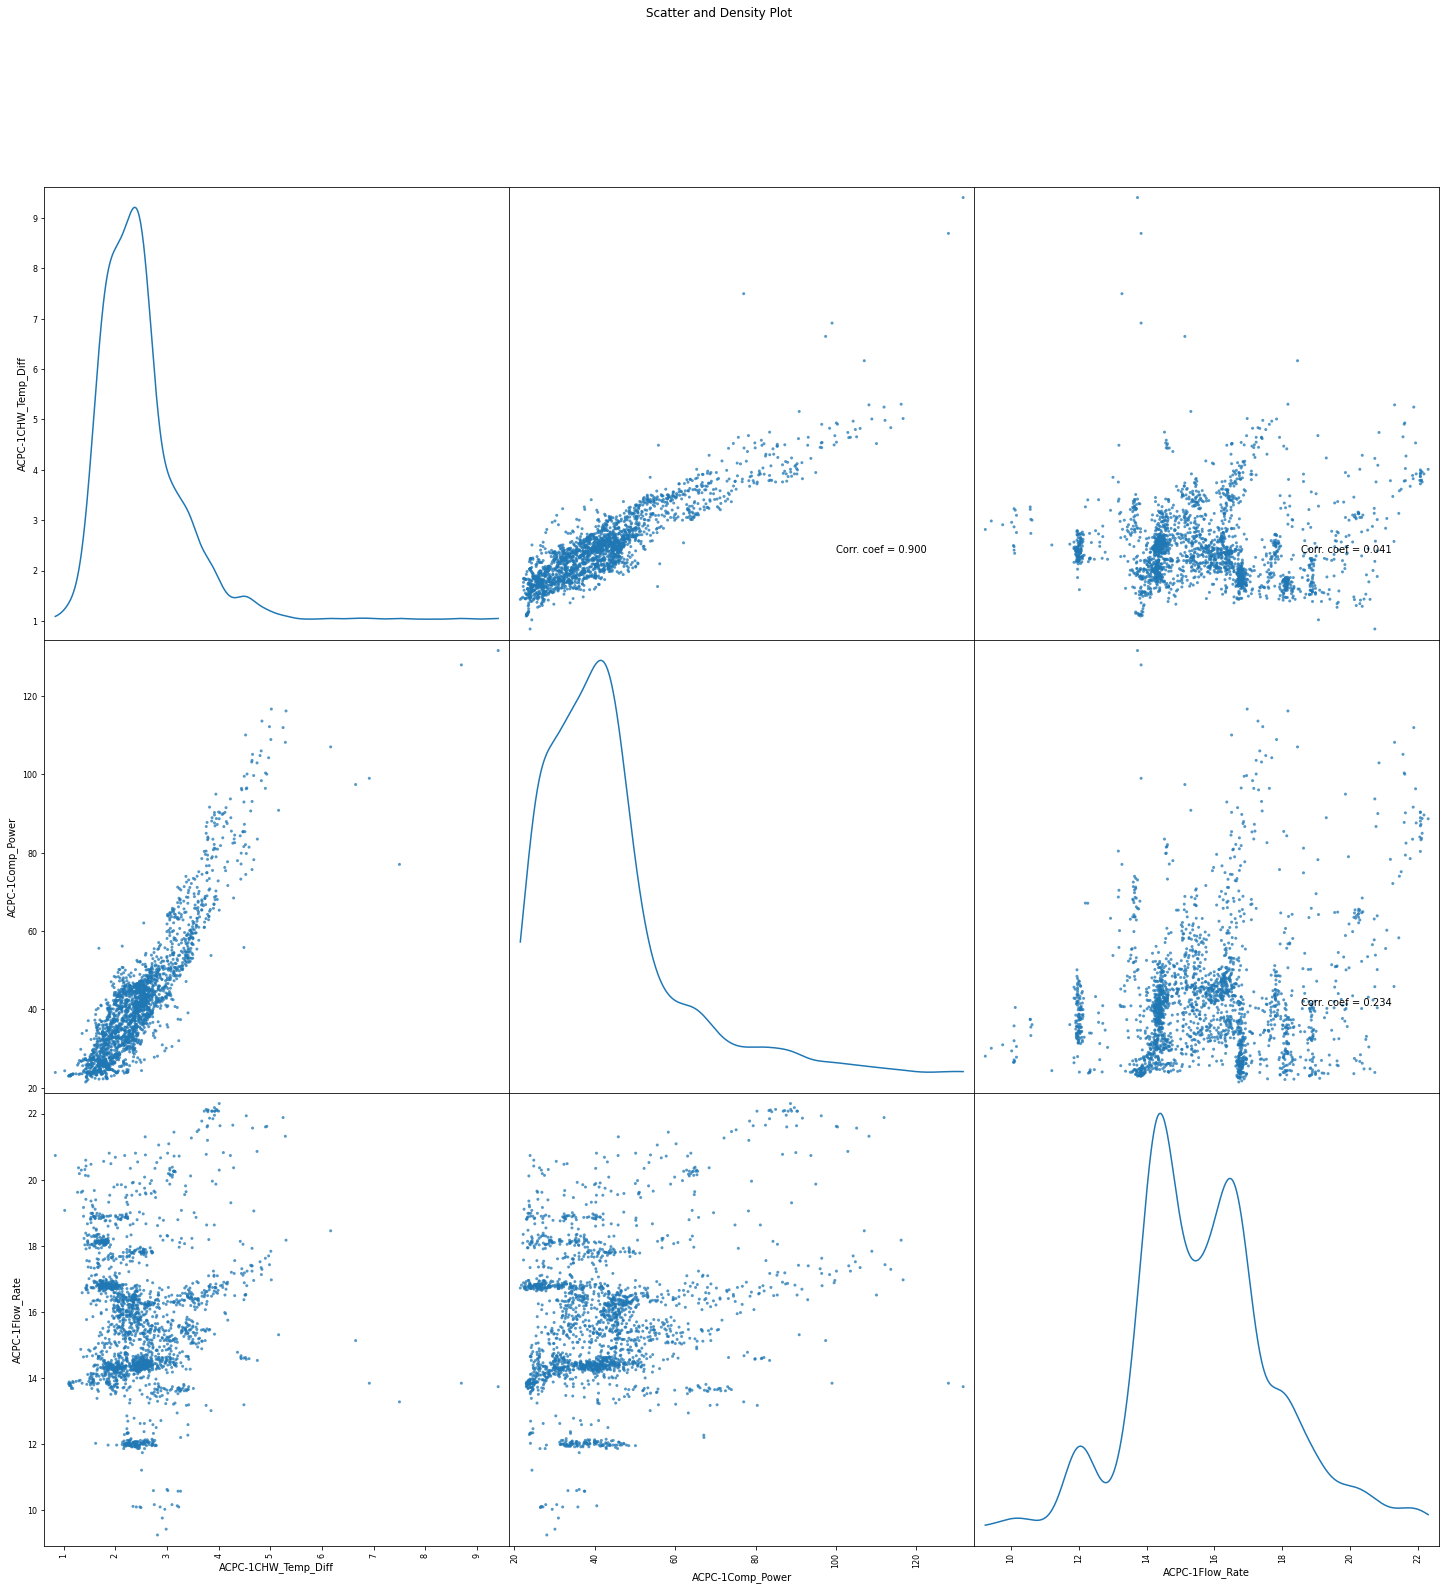

In [47]:
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(data1[['ACPC-1CHW_Temp_Diff','ACPC-1Comp_Power','ACPC-1Flow_Rate']], 25, 10)

We can see that there doesn't appear to be a lot of association between Temp_Diff and Flow_Rate for Chiller 1.

---
Based on my research, I decided to explore the relationship between Temp_Diff and the operation of valve controls.


In [55]:
for col in data1.columns:
  if 'ACPC-1' in col  and 'Control' in col:
    print('*',col,'*')

* ACPC-1Valve_Remote_Control-2 *
* ACPC-1MOV_Open_Control *
* ACPC-1Remote_Control-1 *
* ACPC-1Valve_Remote_Control-1 *
* ACPC-1Remote_Control-2 *
* ACPC-1Start_Stop_Control *


In [75]:
data1[['ACPC-1Valve_Remote_Control-2']].value_counts()

ACPC-1Valve_Remote_Control-2
1.000000                        1126
0.000000                         986
0.500000                          22
0.333333                           5
0.400000                           4
0.666667                           1
0.250000                           1
dtype: int64

In [76]:
#the Kruskal-Wallis H-test tests the null hypothesis that the population median 
#of all of the groups are equal. It is a non-parametric version of ANOVA.
from scipy import stats
x=data1.loc[data1['ACPC-1Valve_Remote_Control-2']==1.000000, ['ACPC-1CHW_Temp_Diff']]
y=data1.loc[data1['ACPC-1Valve_Remote_Control-2']==0.000000, ['ACPC-1CHW_Temp_Diff']]
stats.kruskal(x,y)

KruskalResult(statistic=182.38456807177548, pvalue=1.4614732008811232e-41)

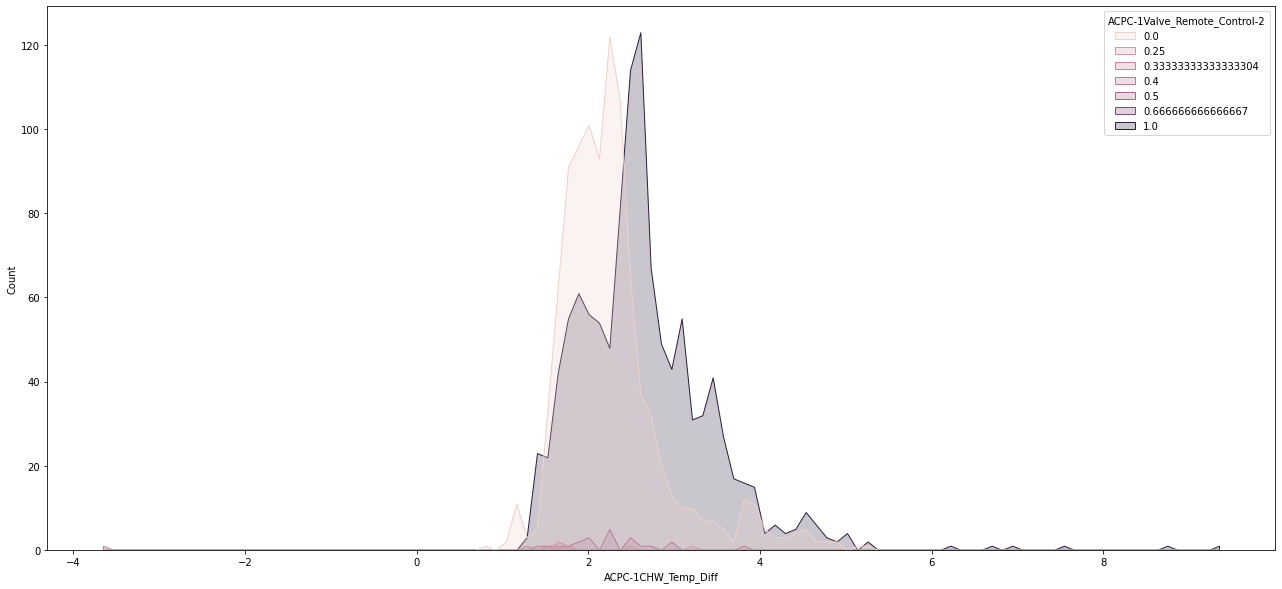

In [68]:
data_control=data1.loc[:, ['ACPC-1Valve_Remote_Control-2', 'ACPC-1CHW_Temp_Diff']]
sns.histplot(data_control, x="ACPC-1CHW_Temp_Diff", hue="ACPC-1Valve_Remote_Control-2", element="poly")

The cells above show that there's a considerable difference in the distribution for Temp_Diff depending on the particular value of the Valve Remote Control-2. It's a bit unclear what the values for the Valve Remote Control mean in real life. If they represent the operational status of the valve, that might indicate that we need to work on the valves. The diagram below shows that Temp_Diff usually rises when the Valve is at 1 and drops when the Valve is at 0. Similar results are achieved for the other valve features in the dataset.

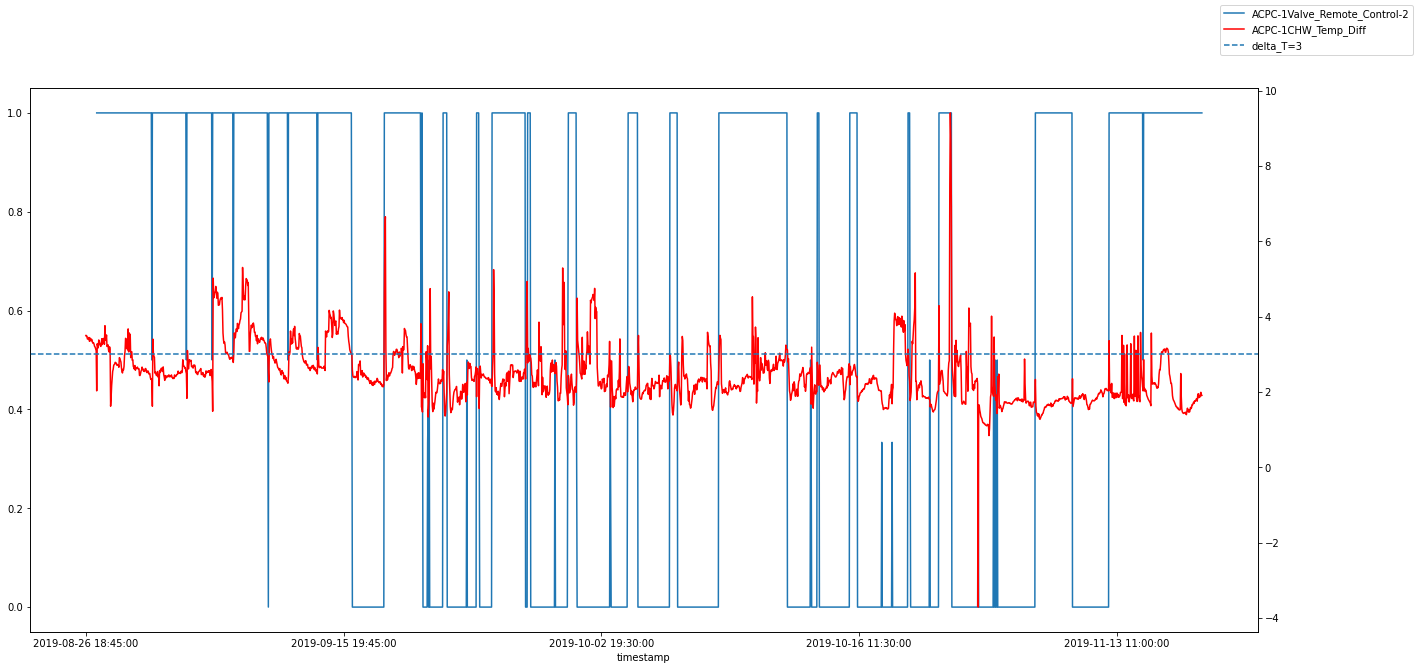

In [79]:
ax = data1.plot(x="timestamp", y="ACPC-1Valve_Remote_Control-2", legend=False)
ax2 = ax.twinx()
data1.plot(x="timestamp", y="ACPC-1CHW_Temp_Diff", ax=ax2, legend=False, color="r")
plt.axhline(3, ls='--',label='delta_T=3')
ax.figure.legend()
plt.show()

In [80]:
#when the chiller is on; let's see how what percent suffer from the low delta_t problem
print(data1[data1['ACPC-1CHW_Temp_Diff'] < 3].shape[0]/data1.shape[0]*100, '%')

80.6555863342567 %


In [81]:
tick_list=[]
for i in range(100, 2200, 300):
  tick_list.append(i)

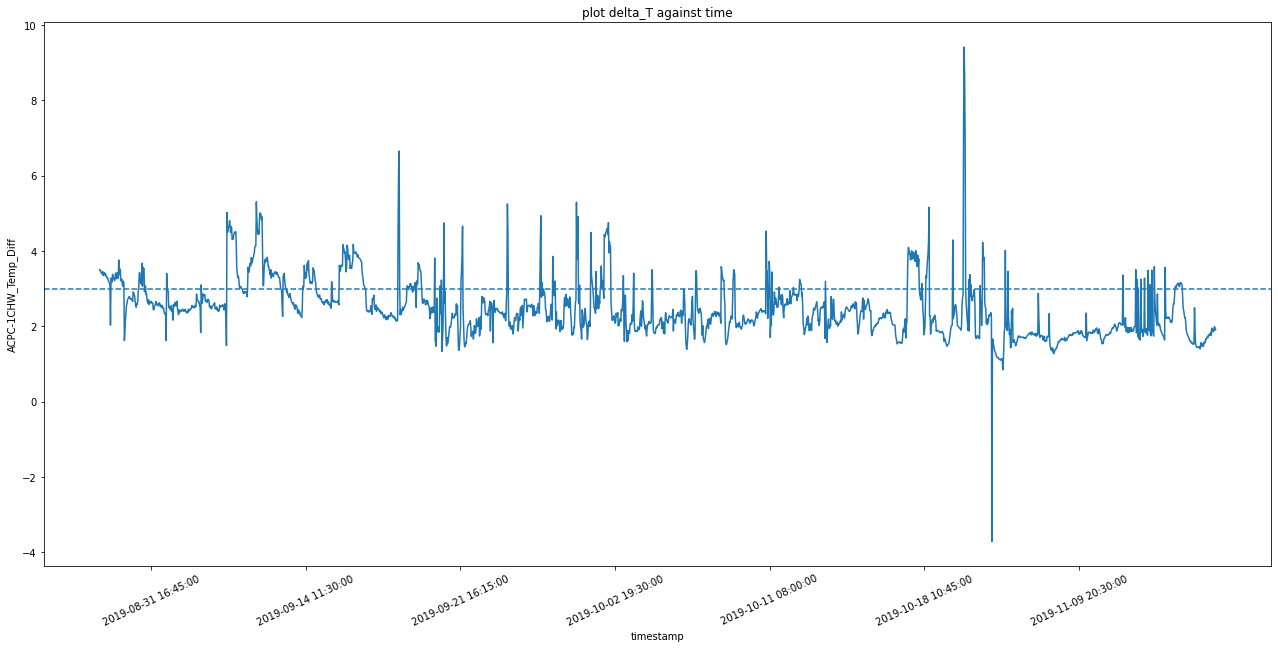

In [85]:
sns.lineplot(x="timestamp", y="ACPC-1CHW_Temp_Diff", data=data1)
plt.xticks(ticks=tick_list, rotation=25)
plt.title('plot delta_T against time')
plt.axhline(3, ls='--', label='delta_T=3')
plt.show()

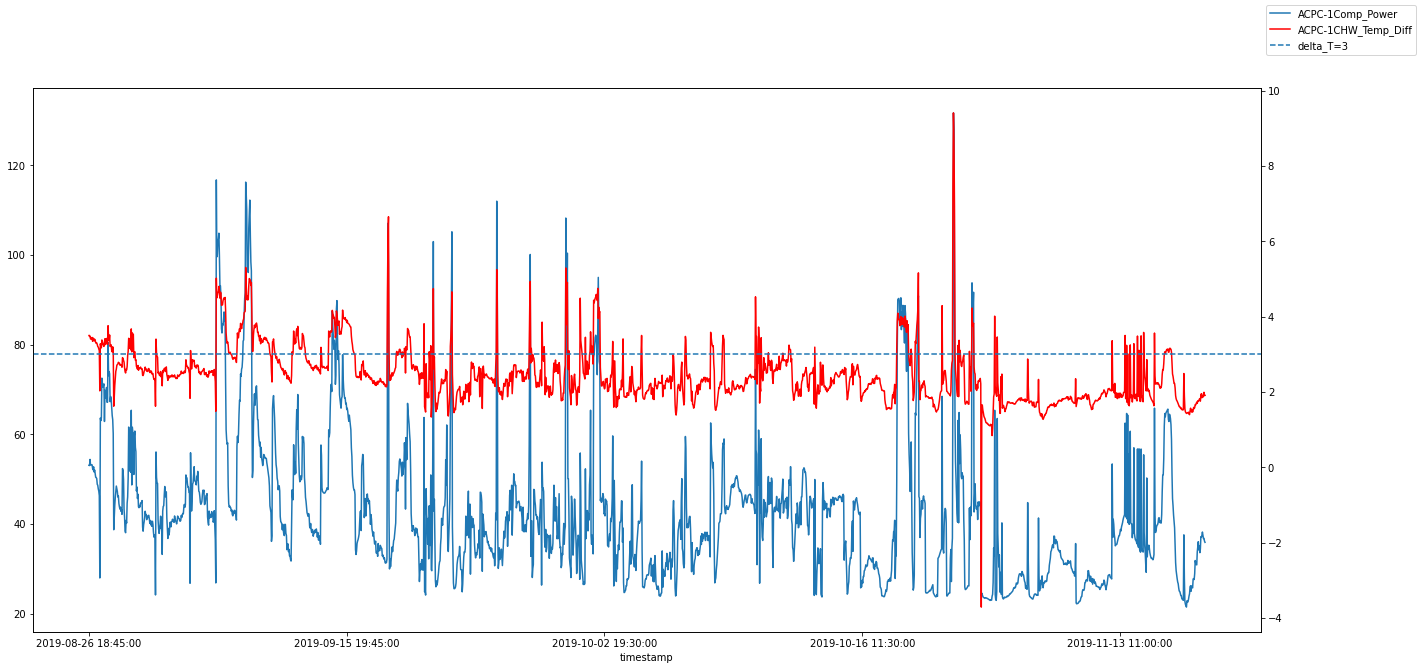

In [91]:
ax = data1.plot(x="timestamp", y="ACPC-1Comp_Power", legend=False)
ax2 = ax.twinx()
data1.plot(x="timestamp", y="ACPC-1CHW_Temp_Diff", ax=ax2, legend=False, color="r")
plt.axhline(3, ls='--', label='delta_T=3')
ax.figure.legend()
plt.show()
#this chart just shows that when temp_diff is low, less power is needed by the chiller

Below, I try to explore the association between Temp_Diff and Flow_Rate again.
While the time-series chart indicates an association, the scatterplot and Spearman correlation coefficient conclude that there isn't much of an association.

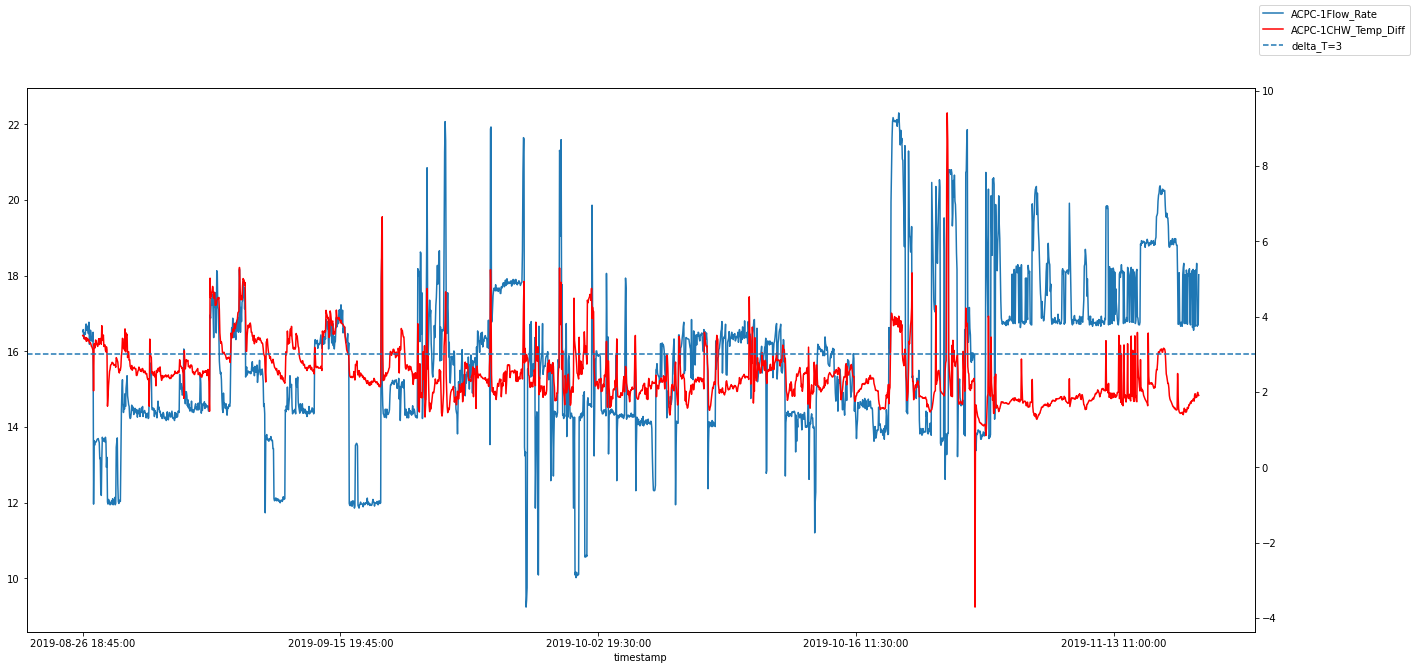

In [89]:
ax = data1.plot(x="timestamp", y="ACPC-1Flow_Rate", legend=False)
ax2 = ax.twinx()
data1.plot(x="timestamp", y="ACPC-1CHW_Temp_Diff", ax=ax2, legend=False, color="r")
plt.axhline(3, ls='--', label='delta_T=3')
ax.figure.legend()
plt.show()

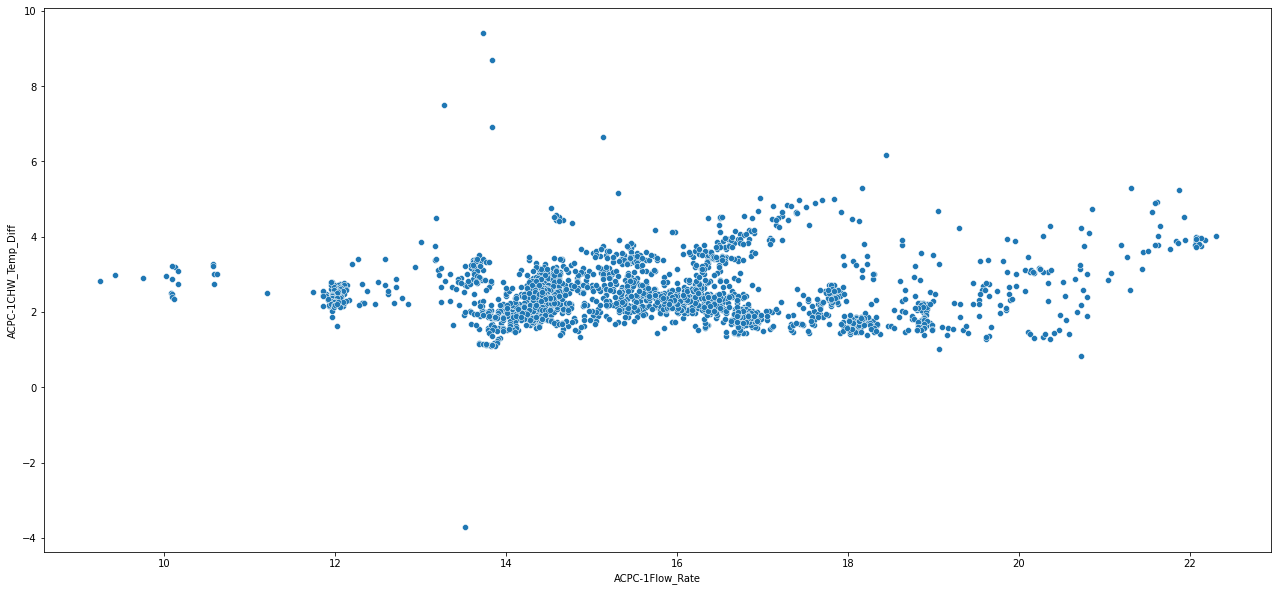

In [93]:
sns.scatterplot(data=data1, x='ACPC-1Flow_Rate', y='ACPC-1CHW_Temp_Diff')

In [94]:
spearmanr(data1['ACPC-1CHW_Temp_Diff'], data1['ACPC-1Flow_Rate'], nan_policy='omit')

SpearmanrResult(correlation=-0.0969741013218677, pvalue=6.147316216855456e-06)

Some other variables that can be explored are the ones that display a high spearman correlation with Temp_Diff. These can be seen below.

In [96]:
# seed random number generator
seed(1)
# calculate spearman's correlation
for col in data1.columns[1:]:
  try:
    coef, p = spearmanr(data1['ACPC-1CHW_Temp_Diff'], data1[col], nan_policy='omit')
  except ValueError:
    pass
  if coef > 0.7:
    print (col, coef, p)

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


ACPC-1Comp_Power 0.8498952788190897 0.0
ACPC-1KVA 0.8406749418693951 0.0
ACPC-1Cooling_Load 0.8689360500730073 0.0
ACPC-1Chiller_Loading_Percent 0.8478560271733352 0.0
ACPC-1CHW_Temp_Diff 1.0 0.0
ACPC-1ACC01_ACPC-1 EM.points.Energy(unsigned) 0.8597678298731416 0.0
Chiller HeaderCHW_Temp_Diff 0.8052954550796939 0.0
